<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Grounded_SAM_Tool_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#please don't run this cell
There are some version issue in base repository<br>
Download Requirements

In [ ]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything

# %cd /content/Grounded-Segment-Anything
# !pip install -q -r requirements.txt --use-deprecated=legacy-resolver
# %cd /content/Grounded-Segment-Anything
# !python -m pip install -e GroundingDINO

#Installing from library package instead of code

In [1]:
!pip -q install groundingdino-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.6 MB/s eta 0:00:00


In [2]:
import PIL
from PIL import Image
import requests
import torch
from io import BytesIO
# if install from github repository
# from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

# if install from python package
from groundingdino.util.inference import annotate, load_image, predict
import torch
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

local_image_path = "inpaint_demo.jpg"
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)

Image downloaded from url: https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg and saved to: inpaint_demo.jpg.


(706, 884, 3)

 (3, 800, 1001)


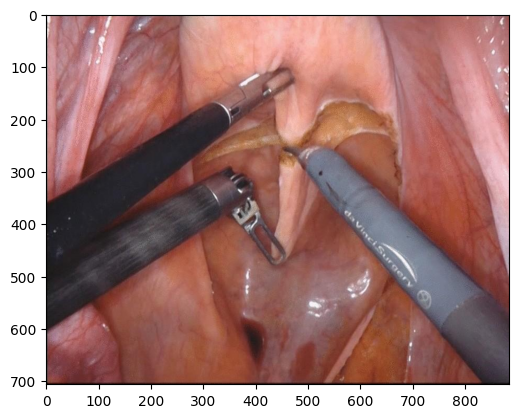

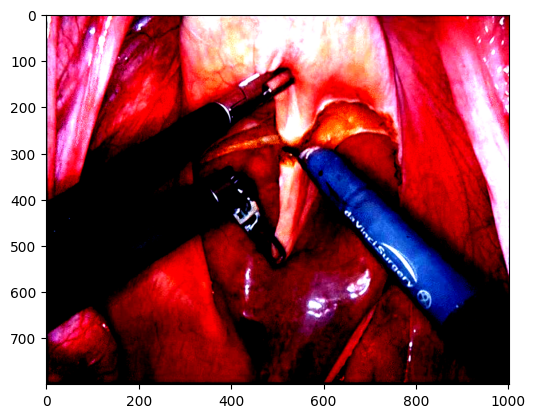

In [3]:
import numpy as np
import matplotlib.pyplot as plt
print(np.array(image_source).shape, np.array(image).shape)
plt.figure()
plt.imshow(np.array(image_source))

plt.figure()
plt.imshow(np.array(image).transpose(1,2,0))

Grounding DINO to Detect Object with Prompt

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


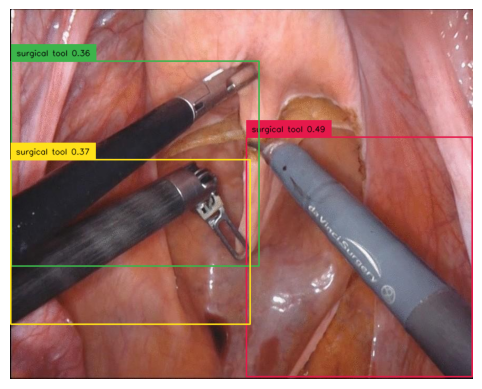

In [4]:
# if install from github repository
# from GroundingDINO.groundingdino.models import build_model
# from GroundingDINO.groundingdino.util import box_ops
# from GroundingDINO.groundingdino.util.slconfig import SLConfig
# from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

import matplotlib.pyplot as plt

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)


def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
predicted_img = Image.fromarray(annotated_frame)
plt.imshow(predicted_img);
plt.axis('OFF');

In [5]:
image.shape, type(image)#c * h * w

(torch.Size([3, 800, 1001]), torch.Tensor)

SAM for Segmentation from Detected Bounding Box:

In [6]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git' torchmetrics

--2023-12-04 18:06:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.31, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   125MB/s    in 24s     

2023-12-04 18:06:24 (103 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.7 MB/s eta 0:00:00


Restart Runtime, please! (if segment_anything not found)

In [7]:
%cd /content/Grounded-Segment-Anything
from segment_anything import build_sam, SamPredictor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

[Errno 2] No such file or directory: '/content/Grounded-Segment-Anything'
/content


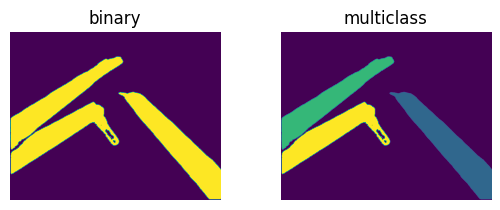

In [8]:
import numpy as np

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
# annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
# instance_seg1 = Image.fromarray(annotated_frame_with_mask)
binary_seg = segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(221)
plt.title('binary')
plt.imshow(binary_seg);
plt.axis('OFF');

import torch
mask_multiclass = torch.zeros((segmented_frame_masks.shape[2:]))
mask_multiclass[segmented_frame_masks[0,0] == 1] = 1
mask_multiclass[segmented_frame_masks[1,0] == 1] = 2
mask_multiclass[segmented_frame_masks[2,0] == 1] = 3

plt.subplot(222)
plt.title('multiclass')
plt.imshow(mask_multiclass);
plt.axis('OFF');


Calculating segmentation metrics: Dice Similarity Coefficient (DSC)

In [ ]:
from torchmetrics.classification import Dice
dice_global = Dice(average='micro')
dice_cls_wise = Dice(average='macro', num_classes=4)
preds = binary_seg.int()
target = binary_seg.int()
binary_dice = dice_global(preds, target)
print('binary dice:', binary_dice)

multiclass_dice = dice_cls_wise(mask_multiclass.int(), mask_multiclass.int())

print('multiclass dice:', multiclass_dice)

binary dice: tensor(1.)
multiclass dice: tensor(1.)


binary dice: tensor(0.9589)


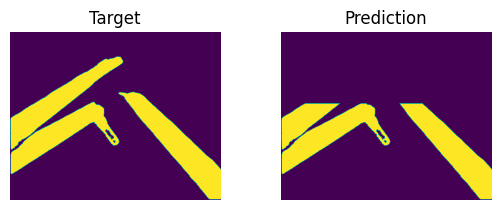

In [ ]:
preds = binary_seg.int()
target = binary_seg.int()

preds[:300,][preds[:300,]==1] = 0
binary_dice = dice_global(preds, target)
print('binary dice:', binary_dice)

plt.subplot(221)
plt.title('Target')
plt.imshow(target);
plt.axis('OFF');

plt.subplot(222)
plt.title('Prediction')
plt.imshow(preds);
plt.axis('OFF');

In [ ]:
import cv2
cv2.imwrite('GT.png', np.array(binary_seg).astype(float))
cv2.imwrite('pred.png', np.array(binary_seg).astype(float))

True

In [ ]:
import torch

input_boxes = [
    [721, 104, 1280, 332],
    [2, 288, 1129, 822],
    [632, 542, 1280, 751]
]
input_boxes = torch.tensor(np.array(input_boxes))
sam_predictor.transform.apply_boxes_torch(input_boxes, [1280, 1024])

tensor([[ 576.6592,   83.2000, 1023.7500,  265.6000],
        [   1.5996,  230.4000,  902.9795,  657.6000],
        [ 505.4766,  433.6000, 1023.7500,  600.8000]])

In [ ]:
DICE=Segmentation
mAP/mIoU= Detection

Filter implementation

In [90]:
import torchvision.transforms.functional as TF
from PIL import Image
import cv2

class perturbation_class:

    def gamma_correction(img):
        seq = []
        gammas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]#np.arange(1,0.1,-.03)
        img = Image.fromarray(img)
        for i in range(len(gammas)):
            z = TF.adjust_gamma(img, gammas[i], gain=1)
            seq.append(z)
        return seq

    def contrast(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_contrast(img, factors[i])
            seq.append(z)
        return seq

    def brightness(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_brightness(img, factors[i])
            seq.append(z)
        return seq

    def sharpness(img):
        seq = []
        #factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        factors = [ -6, -4, -2, 1, 2, 4, 6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_sharpness(img, factors[i])
            seq.append(z)
        return seq

    def gaussian_blur(img):
        seq = []
        ksize = [1, 3, 5, 7, 9, 11, 99]
        img = Image.fromarray(img)
        for i in range(len(ksize)):
            z = TF.gaussian_blur(img, kernel_size=ksize[i])
            seq.append(np.array(z))
        return seq

image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
local_image_path = 'clean_input.png'
urllib.request.urlretrieve(image_url, local_image_path)
original = cv2.imread(local_image_path)
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
filter_name = ['gc', 'con', 'bri', 'sha','blu']
!mkdir perturbed_imgs
cv2.imwrite('perturbed_imgs/origin.png', original)
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    cv2.imwrite('perturbed_imgs/{}_0.png'.format(filter_name[p_idx]), np.array(seq[0]))
    cv2.imwrite('perturbed_imgs/{}_6.png'.format(filter_name[p_idx]), np.array(seq[6]))

mkdir: cannot create directory ‘perturbed_imgs’: File exists


Segmentation performance with clean image Vs filtering:

Detection mIoU: tensor(0.6107)
Segmentation dice: tensor(0.5979)


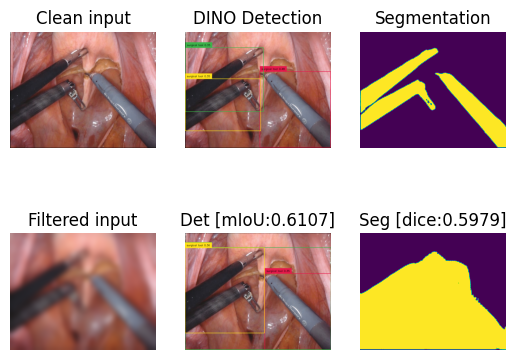

In [94]:
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
from groundingdino.util.inference import annotate, load_image, predict
#Clean Input
#input preparation
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
local_image_path = 'clean_input.png'
urllib.request.urlretrieve(image_url, local_image_path)
img = Image.open(local_image_path)
plt.subplot(231)
plt.axis('OFF')
plt.title('Clean input')
plt.imshow(img)

#DINO Detection
image_source, image = load_image(local_image_path)
annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
predicted_img = Image.fromarray(annotated_frame)
plt.subplot(232)
plt.imshow(predicted_img)
plt.axis('OFF')
plt.title('DINO Detection')

#SAM Binary Segmentation
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
binary_seg = segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(233)
plt.imshow(binary_seg)
plt.axis('OFF')
plt.title('Segmentation');

################################################################################
#Filtered Input
filtered_image_path = '/content/perturbed_imgs/blu_6.png'
# filtered_img = Image.open(filtered_image_path)
filtered_image_source, filtered_image = load_image(filtered_image_path)
plt.subplot(234)
plt.axis('OFF')
plt.title('Filtered input')
plt.imshow(filtered_image_source)

#DINO Detection
filtered_image_source, filtered_image = load_image(filtered_image_path)
filtered_annotated_frame, filtered_detected_boxes = detect(filtered_image, text_prompt="surgical tool", model=groundingdino_model)
filtered_predicted_img = Image.fromarray(filtered_annotated_frame)
plt.subplot(235)
plt.imshow(filtered_predicted_img)
plt.axis('OFF')

from groundingdino.util import box_ops
clean_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(detected_boxes)
filtered_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_detected_boxes)
IoU_All = box_ops.generalized_box_iou(clean_boxes_xyxy, filtered_boxes_xyxy)
mIoU = IoU_All.diag().sum()/len(clean_boxes_xyxy)
plt.title('Det [mIoU:{:0.4f}]'.format(mIoU))
print('Detection mIoU:', mIoU)

#SAM Binary Segmentation
filtered_segmented_frame_masks = segment(filtered_image_source, sam_predictor, boxes=filtered_detected_boxes)
filtered_binary_seg = filtered_segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(236)
plt.imshow(filtered_binary_seg)
plt.axis('OFF')

#Dice Calculation
from torchmetrics.classification import Dice
dice_global = Dice(average='micro')
target = binary_seg.int()# prediction of clean input considered as target
filtered_preds = filtered_binary_seg.int()
binary_dice = dice_global(filtered_preds, target)
plt.title('Seg [dice:{:0.4f}]'.format(binary_dice));
print('Segmentation dice:', binary_dice)

Text(0.5, 1.0, 'DINO Detection')

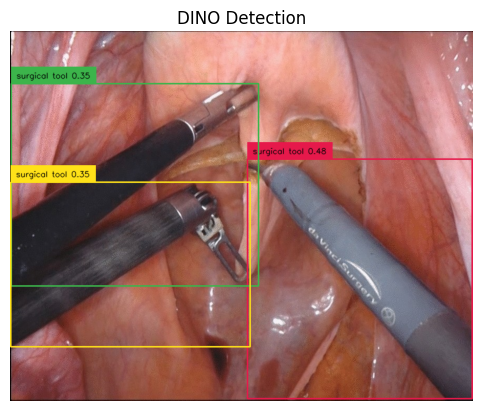

In [40]:
image_source, image = load_image(local_image_path)
annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
predicted_img = Image.fromarray(annotated_frame)

plt.imshow(predicted_img)
plt.axis('OFF')
plt.title('DINO Detection')

In [70]:
from groundingdino.util import box_ops
clean_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(detected_boxes)
filtered_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_detected_boxes)
IoU_All = box_ops.generalized_box_iou(clean_boxes_xyxy, filtered_boxes_xyxy)
mIoU = IoU_All.diag().sum()/len(clean_boxes_xyxy)

In [75]:
IoU_All.diag().sum()/len(clean_boxes_xyxy)

tensor(0.6107)

In [52]:
H, W, C = annotated_frame.shape
box = detected_boxes[0] * torch.Tensor([W, H, W, H])

In [74]:
len(clean_boxes_xyxy)

3

In [54]:
box[:2] -= box[2:] / 2
box[2:] += box[:2]

box

tensor([453.5032, 244.6827, 882.7383, 701.9539])

In [ ]:
x0, y0, x1, y1 = box
x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

In [ ]:
from groundingdino.demo.inference_on_a_image import plot_boxes_to_image

In [59]:
from groundingdino.util import box_ops
cxcywh_to_xyxy = box_ops.box_cxcywh_to_xyxy(detected_boxes)
cxcywh_to_xyxy

tensor([[0.5130, 0.3466, 0.9986, 0.9943],
        [0.0025, 0.1417, 0.5370, 0.6892],
        [0.0016, 0.4087, 0.5187, 0.8529]])